### Setup

In [5]:
import sys
!{sys.executable} -m pip install git+https://github.com/geomstats/geomstats.git
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/geomstats/geomstats.git to /private/var/folders/zk/7jfz5x6n6vbg7vwv_n6ckhkc0000gn/T/pip-req-build-y_n__zrd
  Running command git clone -q https://github.com/geomstats/geomstats.git /private/var/folders/zk/7jfz5x6n6vbg7vwv_n6ckhkc0000gn/T/pip-req-build-y_n__zrd
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/pyt

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import geomstats.backend as gs

gs.random.seed(2021)

INFO: Using numpy backend


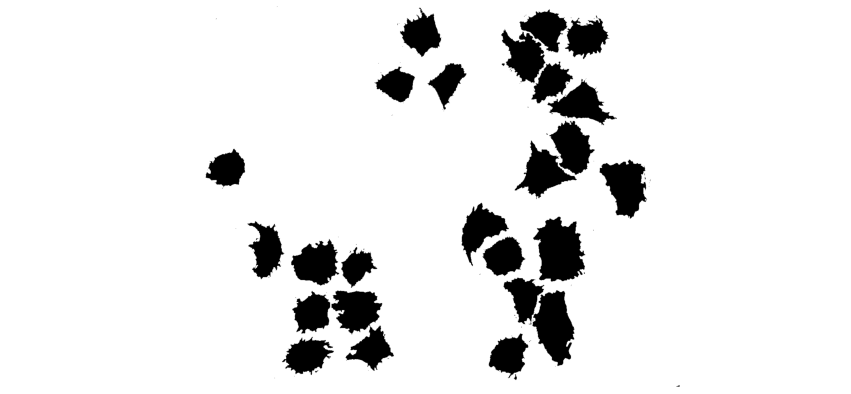

In [4]:
import cv2

img = cv2.imread('datasets/binary_image.tif')
plt.figure(figsize=(15, 7))
plt.axis('equal')
plt.axis('off')
plt.imshow(img)

In [7]:
def load_cells():
    """Load cell data.

    Returns
    -------
    cells : list of 2D discrete curves
        Each curve represents the boundary of a cell, their lengths
        are not necessarily equal.
    cell_lines : array of strings
        List of the cell lines of each cell.
    treatments : array of strings
        List of the treatments given to each cell.
    """
    with open("datasets/cells.txt") as cells_file:
        cells = cells_file.read().split('\n\n')
    for i, cell in enumerate(cells):
        cell = cell.split('\n')
        curve = []
        for point in cell:
            coords = [int(coord) for coord in point.split()]
            curve.append(coords)
        cells[i] = gs.array(curve)
    with open("datasets/cell_lines.txt") as cell_lines_file:
        cell_lines = gs.array(cell_lines_file.read().split('\n'))
    with open("datasets/treatments.txt") as treatments_file:
        treatments = gs.array(treatments_file.read().split('\n'))
    return cells, cell_lines, treatments

In [8]:
cells, cell_lines, treatments = load_cells()
print(f'Total number of cells : {len(cells)}')

Total number of cells : 650


In [9]:
for treatment in ["control", "cytd", "jasp"]:
    nb_dlm8 = gs.sum((treatments == treatment) & (cell_lines == "dlm8"))
    nb_dunn = gs.sum((treatments == treatment) & (cell_lines == "dunn"))
    print(f'{treatment} : {nb_dlm8} DLM8 and {nb_dunn} DUNN')

control : 114 DLM8 and 204 DUNN
cytd : 82 DLM8 and 93 DUNN
jasp : 62 DLM8 and 95 DUNN


In [10]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length/nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index)*(curve[(index + 1)%old_length] - curve[index])
        pos += incr
    return interpolation

nb_sampling = 100

(1116.375, 1229.125, -283.2620000000003, -199.178)

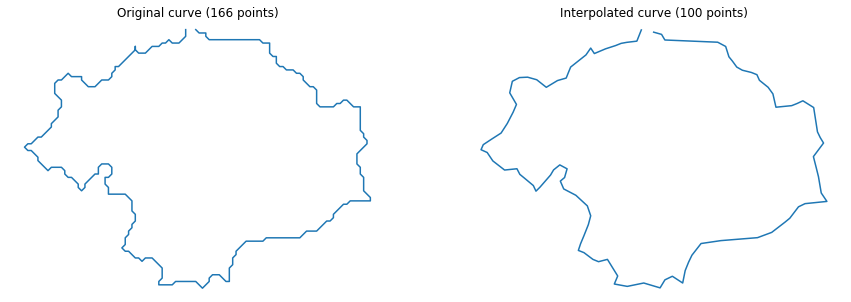

In [11]:
i = gs.random.randint(len(cells))
cell = cells[i]
cell_interpolation = interpolate(cells[i], nb_sampling)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell[:, 0], cell[:, 1])
plt.axis('equal')
plt.title(f"Original curve ({len(cell)} points)")
plt.axis('off')

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis('equal')
plt.title(f"Interpolated curve ({nb_sampling} points)")
plt.axis('off')

In [12]:
for i in range(len(cells)):
    cells[i] = interpolate(cells[i], nb_sampling)

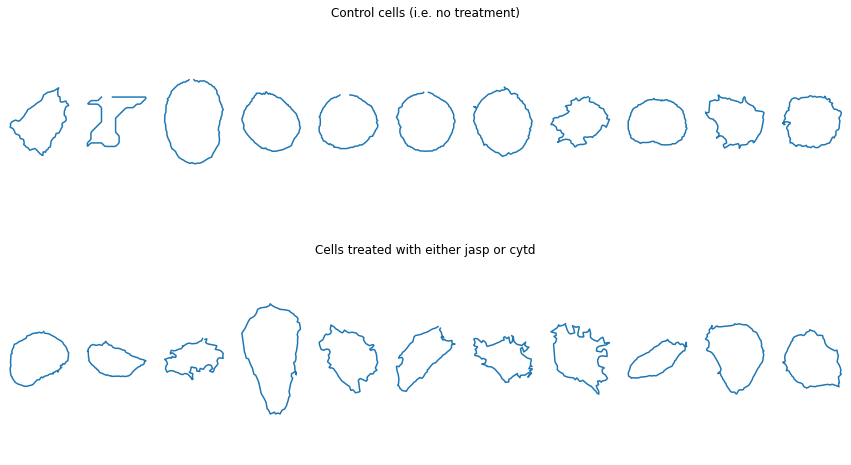

In [13]:
nb_cells = 11

control_i = gs.random.randint(0, 300, size=nb_cells)
jasp_i = gs.random.randint(500, 600, size=nb_cells)

fig = plt.figure(figsize=(15, 8))

for i in range(nb_cells):
    cell = cells[control_i[i]]
    fig.add_subplot(2, nb_cells, i + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Control cells (i.e. no treatment)")
    plt.axis('equal')
    plt.axis('off')
    
for i in range(nb_cells):
    cell = cells[jasp_i[i]]
    fig.add_subplot(2, nb_cells, i + nb_cells + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Cells treated with either jasp or cytd")
    plt.axis('equal')
    plt.axis('off')

In [14]:
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

m_ambient = 2
k_landmarks = nb_sampling

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric

cells_preshape = preshape.projection(cells)

base_curve = cells_preshape[0]

def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift)%nb_sampling] for i in range(nb_sampling)]
        aligned = preshape.align(point=gs.array(reparametrized), base_point=gs.array(base_curve))
        distances[shift] = matrices_metric.norm(gs.array(aligned) - gs.array(base_curve))
    shift_min = gs.argmin(distances)
    reparametrized_min = [curve[(i + shift_min)%nb_sampling] for i in range(nb_sampling)]
    aligned_curve = preshape.align(point=gs.array(reparametrized_min), base_point=gs.array(base_curve))
    return aligned_curve

cells_shape = [exhaustive_align(curve, base_curve) for curve in cells_preshape]

Text(0.5, 1.0, 'Aligned curve')

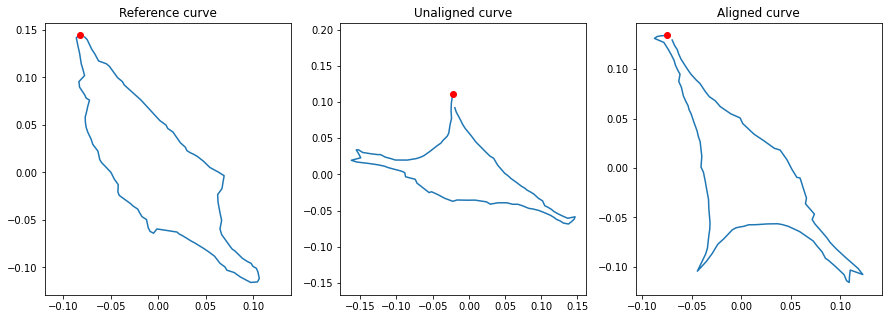

In [15]:
i = gs.random.randint(len(cells_shape))

base_cell = cells_preshape[0]
unaligned_cell = cells_preshape[i]
aligned_cell = cells_shape[i]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(base_cell[:, 0], base_cell[:, 1])
plt.plot(base_cell[0, 0], base_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Aligned curve")

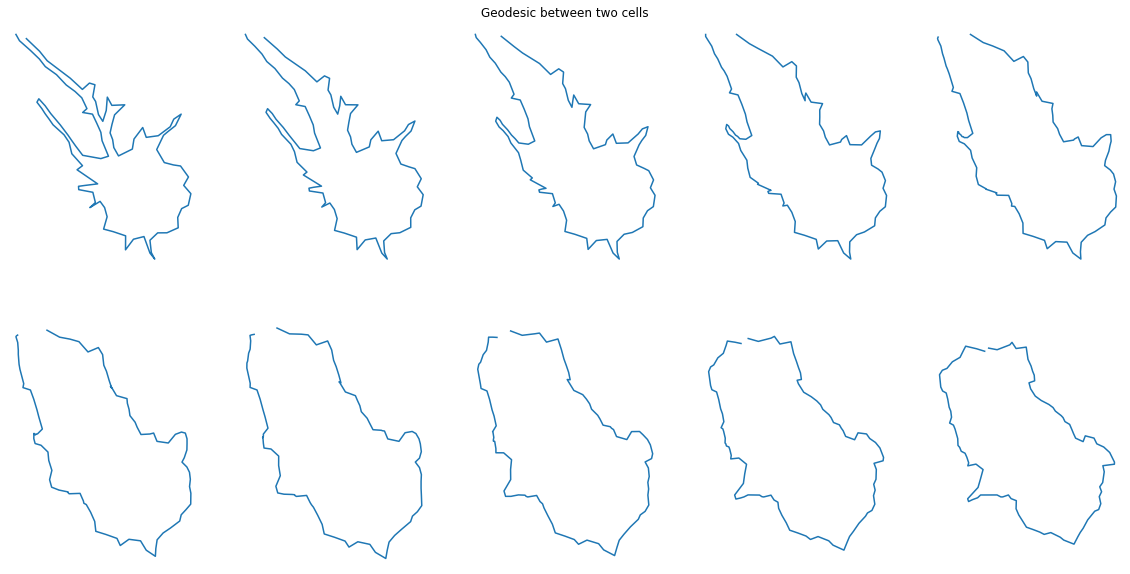

In [16]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric

curves = DiscreteCurves(R2)
metric = curves.srv_metric
i, j = gs.random.randint(len(cells_shape), size=2)

geodesic = metric.geodesic(initial_curve=cells_shape[i], end_curve=cells_shape[j])

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between two cells")
plt.axis('off')

for i, curve in enumerate(points):
    fig.add_subplot(2, int(len(points)/2), i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')

In [19]:
N = len(cells_shape)
# srvs = [metric.square_root_velocity(cell) for cell in cells_shape]
dist_matrix = gs.zeros((N, N))

for i in range(N):
    for j in range(i, N):
        # dist = curves.l2_metric(nb_sampling - 1).dist(cells_shape[i], cells_shape[j])
        try:
            dist = curves.srv_metric.dist(cells_shape[i], cells_shape[j])
            dist_matrix[i, j] = dist_matrix[j, i] = dist
        except Exception as e:
            print("i:", i, "j:", j)

i: 0 j: 151
i: 1 j: 151
i: 2 j: 151
i: 3 j: 151
i: 4 j: 151
i: 5 j: 151
i: 6 j: 151
i: 7 j: 151
i: 8 j: 151
i: 9 j: 151
i: 10 j: 151
i: 11 j: 151
i: 12 j: 151
i: 13 j: 151
i: 14 j: 151
i: 15 j: 151
i: 16 j: 151
i: 17 j: 151
i: 18 j: 151
i: 19 j: 151
i: 20 j: 151
i: 21 j: 151
i: 22 j: 151
i: 23 j: 151
i: 24 j: 151
i: 25 j: 151
i: 26 j: 151
i: 27 j: 151
i: 28 j: 151
i: 29 j: 151
i: 30 j: 151
i: 31 j: 151
i: 32 j: 151
i: 33 j: 151
i: 34 j: 151
i: 35 j: 151
i: 36 j: 151
i: 37 j: 151
i: 38 j: 151
i: 39 j: 151
i: 40 j: 151
i: 41 j: 151
i: 42 j: 151
i: 43 j: 151
i: 44 j: 151
i: 45 j: 151
i: 46 j: 151
i: 47 j: 151
i: 48 j: 151
i: 49 j: 151
i: 50 j: 151
i: 51 j: 151
i: 52 j: 151
i: 53 j: 151
i: 54 j: 151
i: 55 j: 151
i: 56 j: 151
i: 57 j: 151
i: 58 j: 151
i: 59 j: 151
i: 60 j: 151
i: 61 j: 151
i: 62 j: 151
i: 63 j: 151
i: 64 j: 151
i: 65 j: 151
i: 66 j: 151
i: 67 j: 151
i: 68 j: 151
i: 69 j: 151
i: 70 j: 151
i: 71 j: 151
i: 72 j: 151
i: 73 j: 151
i: 74 j: 151
i: 75 j: 151
i: 76 j: 151
i: 77 j: 

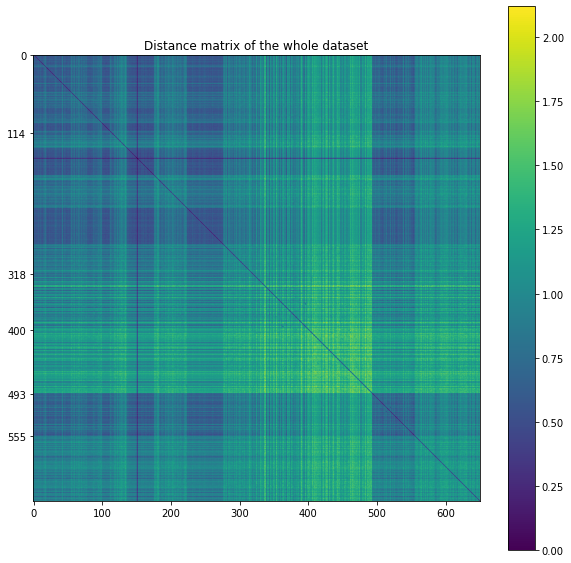

In [22]:
plt.figure(figsize=(10, 10))
plt.title("Distance matrix of the whole dataset")
plt.imshow(dist_matrix)
ticks = [0, 114, 318, 400, 493, 555]
plt.yticks(ticks)
plt.colorbar()

In [23]:
dlm8_control_indexes = gs.where((cell_lines == "dlm8") & (treatments == "control"))[0]
dlm8_cytd_indexes = gs.where((cell_lines == "dlm8") & (treatments == "cytd"))[0]
dlm8_jasp_indexes = gs.where((cell_lines == "dlm8") & (treatments == "jasp"))[0]

dlm8_indexes = gs.concatenate((dlm8_jasp_indexes, dlm8_cytd_indexes, dlm8_control_indexes))
dlm8_matrix = dist_matrix[dlm8_indexes][:, dlm8_indexes]


dunn_control_indexes = gs.where((cell_lines == "dunn") & (treatments == "control"))[0] # indices to use
dunn_cytd_indexes = gs.where((cell_lines == "dunn") & (treatments == "cytd"))[0]
dunn_jasp_indexes = gs.where((cell_lines == "dunn") & (treatments == "jasp"))[0]

dunn_indexes = gs.concatenate((dunn_control_indexes, dunn_cytd_indexes, dunn_jasp_indexes))
dunn_matrix = dist_matrix[dunn_indexes][:, dunn_indexes]

dunn_control_matrix = dist_matrix[dunn_control_indexes][:, dunn_control_indexes]


In [33]:
print(dunn_control_matrix)
print(dunn_control_matrix.shape)
np.savetxt("datasets/dunn_control_matrix.txt", dunn_control_matrix)
# print(np.array(cells_shape).shape)

[[0.         0.64824496 0.81837053 ... 0.99860796 0.97071168 0.87376201]
 [0.64824496 0.         0.73575986 ... 0.860406   0.94290662 0.9254851 ]
 [0.81837053 0.73575986 0.         ... 0.99023615 1.09410381 1.09844986]
 ...
 [0.99860796 0.860406   0.99023615 ... 0.         1.23771934 1.15864755]
 [0.97071168 0.94290662 1.09410381 ... 1.23771934 0.         1.15992269]
 [0.87376201 0.9254851  1.09844986 ... 1.15864755 1.15992269 0.        ]]
(204, 204)
